In [65]:
!pip install alpha_vantage

Defaulting to user installation because normal site-packages is not writeable


In [66]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


In [67]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from alpha_vantage.timeseries import TimeSeries
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM

In [69]:
# Define stock tickers for analysis and fetching data of multiple stocks

In [70]:
tickers = ["TSLA", "AAPL", "MSFT", "GOOGL", "AMZN" ,"ORCL" ,"INTC" ,"NVDA" ,"META" ,"BABA"]  # Add more tickers as needed

In [71]:
# Function to fetch intraday data for multiple stocks

In [72]:
def fetch_stock_data(ticker):                                             # Using yahoo finance
    data = yf.download(ticker, interval='5m', period='5d')
    data.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
    data['Return'] = data['close'].pct_change()
    data['Target'] = (data['close'].shift(-1) > data['close']).astype(int)
    data.dropna(inplace=True)
    return data

In [73]:
# Fetch and process data for all tickers

In [74]:
all_data = {}
for ticker in tickers:
    all_data[ticker] = fetch_stock_data(ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [75]:
all_data[tickers[0]].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 389 entries, 2025-01-02 14:35:00+00:00 to 2025-01-08 20:55:00+00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       389 non-null    float64
 1   high       389 non-null    float64
 2   low        389 non-null    float64
 3   close      389 non-null    float64
 4   adj_close  389 non-null    float64
 5   volume     389 non-null    int64  
 6   Return     389 non-null    float64
 7   Target     389 non-null    int32  
dtypes: float64(6), int32(1), int64(1)
memory usage: 25.8 KB


In [76]:
all_data[tickers[0]].head()

,open,high,low,close,adj_close,volume,Return,Target
Datetime,,,,,,,,
2025-01-02 14:35:00+00:00,380.504791,380.504791,382.850006,373.410004,381.850006,6201608,-0.021719,1
2025-01-02 14:40:00+00:00,384.750000,384.750000,386.309998,378.899994,380.420013,3603463,0.014702,1
2025-01-02 14:45:00+00:00,388.343414,388.343414,388.440002,383.873505,384.875000,2654646,0.013126,1
2025-01-02 14:50:00+00:00,389.334991,389.334991,389.600006,386.109985,388.339996,2314309,0.005826,1
2025-01-02 14:55:00+00:00,388.345001,388.345001,389.779999,387.690002,389.367004,1745529,0.004092,0


In [77]:
all_data[tickers[0]].tail()

,open,high,low,close,adj_close,volume,Return,Target
Datetime,,,,,,,,
2025-01-08 20:35:00+00:00,394.890106,394.890106,396.480011,394.870087,395.850006,467147,-0.002123,0
2025-01-08 20:40:00+00:00,396.976593,396.976593,397.000000,394.750000,395.049988,549774,-0.000304,1
2025-01-08 20:45:00+00:00,397.039886,397.039886,397.389893,396.372498,396.820007,717209,0.004110,0
2025-01-08 20:50:00+00:00,397.470001,397.470001,397.890015,395.769989,396.924988,1182022,-0.001520,0
2025-01-08 20:55:00+00:00,395.000000,395.000000,397.239990,394.500000,397.239990,1795522,-0.003209,0


In [78]:
# Analyze market hours only

In [79]:
def filter_market_hours(data):
    market = data.between_time('09:30:00', '16:00:00').copy()
    market.sort_index(inplace=True)
    return market

In [80]:
for ticker in tickers:
    all_data[ticker] = filter_market_hours(all_data[ticker])

In [81]:
# Creating features and target for Machine learning

In [82]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [83]:
def add_technical_indicators(data):
    data['SMA_5'] = data['close'].rolling(window=5).mean()  # 5-period simple moving average
    data['SMA_20'] = data['close'].rolling(window=20).mean()  # 20-period simple moving average
    data['RSI'] = compute_rsi(data['close'])  # RSI calculation
    data.dropna(inplace=True)  # Drop NaN values
    return data

In [84]:
for ticker in tickers:
    all_data[ticker] = add_technical_indicators(all_data[ticker])

In [85]:
combined_data = pd.concat([df.assign(ticker=ticker) for ticker, df in all_data.items()])
X = combined_data[['Return', 'SMA_5', 'SMA_20', 'RSI']]
y = combined_data['Target']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [87]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [88]:
#Using GradientBoostingClassifier(HYperparameter tuning included)

In [89]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

In [90]:
gb_model = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, 
                           scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters found for Gradient Boosting: ", grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found for Gradient Boosting:  {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 50}


In [91]:
# Cross-Validation for Gradient Boosting
cv_scores = cross_val_score(gb_model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 Scores for Gradient Boosting: ", cv_scores)
print("Mean F1 Score: ", np.mean(cv_scores))

Cross-Validation F1 Scores for Gradient Boosting:  [0.68224299 0.40298507 0.58139535 0.37313433 0.69369369]
Mean F1 Score:  0.5466902872340367


In [92]:
gb_hyp_model = GradientBoostingClassifier(**grid_search.best_params_)
gb_hyp_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, min_samples_split=10,
                           n_estimators=50)

In [93]:
cv_scores = cross_val_score(gb_hyp_model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 Scores for Gradient Boosting(tuned): ", cv_scores)
print("Mean F1 Score: ", np.mean(cv_scores))

Cross-Validation F1 Scores for Gradient Boosting(tuned):  [0.67281106 0.68468468 0.69683258 0.64321608 0.70222222]
Mean F1 Score:  0.6799533252804543


In [94]:
predictions_gb_hyp = gb_hyp_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions_gb_hyp)
f1 = f1_score(y_test, predictions_gb_hyp)
precision = precision_score(y_test, predictions_gb_hyp)
recall = recall_score(y_test, predictions_gb_hyp)

print(f"Gradient Boosting Model Accuracy: {accuracy:.2f}")
print(f"Gradient Boosting F1 Score: {f1:.2f}")
print(f"Gradient Boosting Precision: {precision:.2f}")
print(f"Gradient Boosting Recall: {recall:.2f}")

Gradient Boosting Model Accuracy: 0.54
Gradient Boosting F1 Score: 0.65
Gradient Boosting Precision: 0.52
Gradient Boosting Recall: 0.87


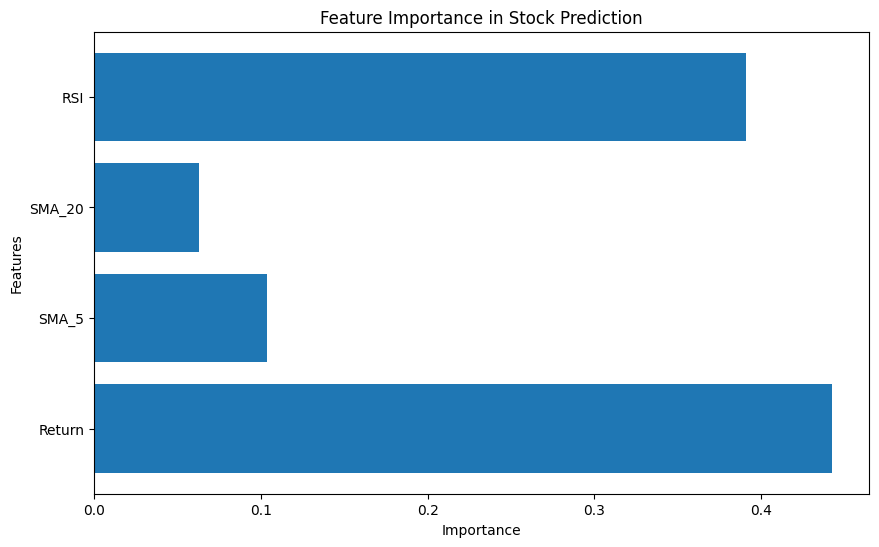

In [95]:
plt.figure(figsize=(10, 6))
plt.barh(['Return', 'SMA_5', 'SMA_20', 'RSI'], gb_hyp_model.feature_importances_)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Stock Prediction')
plt.show()

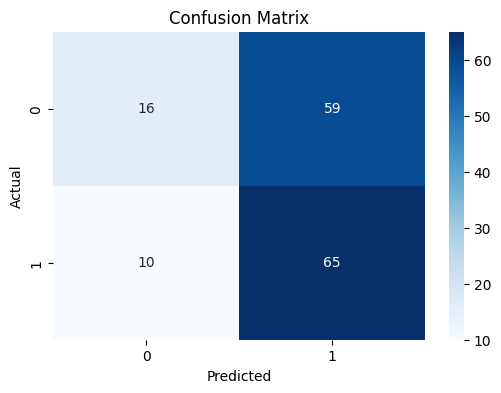

In [96]:
conf_matrix = confusion_matrix(y_test, predictions_gb_hyp)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [97]:
def predict_trending_stocks(data, model, scaler):
    tomorrow_predictions = {}
    for ticker in tickers:
        stock_data = data[ticker]
        X_future = stock_data[['Return', 'SMA_5', 'SMA_20', 'RSI']].dropna().tail(1)  
        if not X_future.empty:
            X_future_scaled = scaler.transform(X_future)
            prediction = model.predict(X_future_scaled)[0]
            tomorrow_predictions[ticker] = "Up" if prediction == 1 else "Down"
        else:
            tomorrow_predictions[ticker] = "No Data"
    return tomorrow_predictions

In [98]:
trending_stocks = predict_trending_stocks(all_data, gb_hyp_model, scaler)
print("Trending Stocks for Tomorrow:")
print(trending_stocks)

Trending Stocks for Tomorrow:
{'TSLA': 'Up', 'AAPL': 'Up', 'MSFT': 'Up', 'GOOGL': 'Down', 'AMZN': 'Up', 'ORCL': 'Up', 'INTC': 'Down', 'NVDA': 'Down', 'META': 'Up', 'BABA': 'Up'}


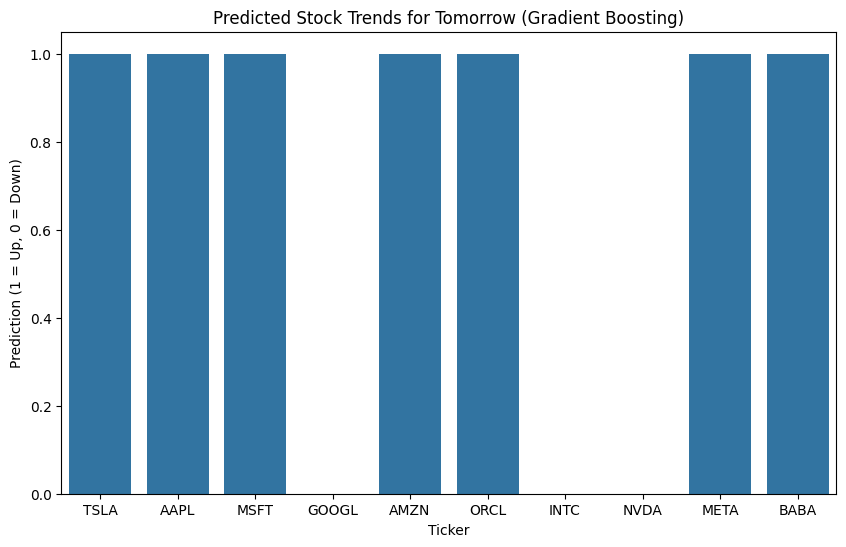

In [99]:
plt.figure(figsize=(10, 6))
trending_df = pd.DataFrame(list(trending_stocks.items()), columns=['Ticker', 'Prediction'])
trending_df['Prediction'] = trending_df['Prediction'].map({'Up': 1, 'Down': 0, 'No Data': None})
sns.barplot(x='Ticker', y='Prediction', data=trending_df.dropna())
plt.ylabel('Prediction (1 = Up, 0 = Down)')
plt.title('Predicted Stock Trends for Tomorrow (Gradient Boosting)')
plt.show()

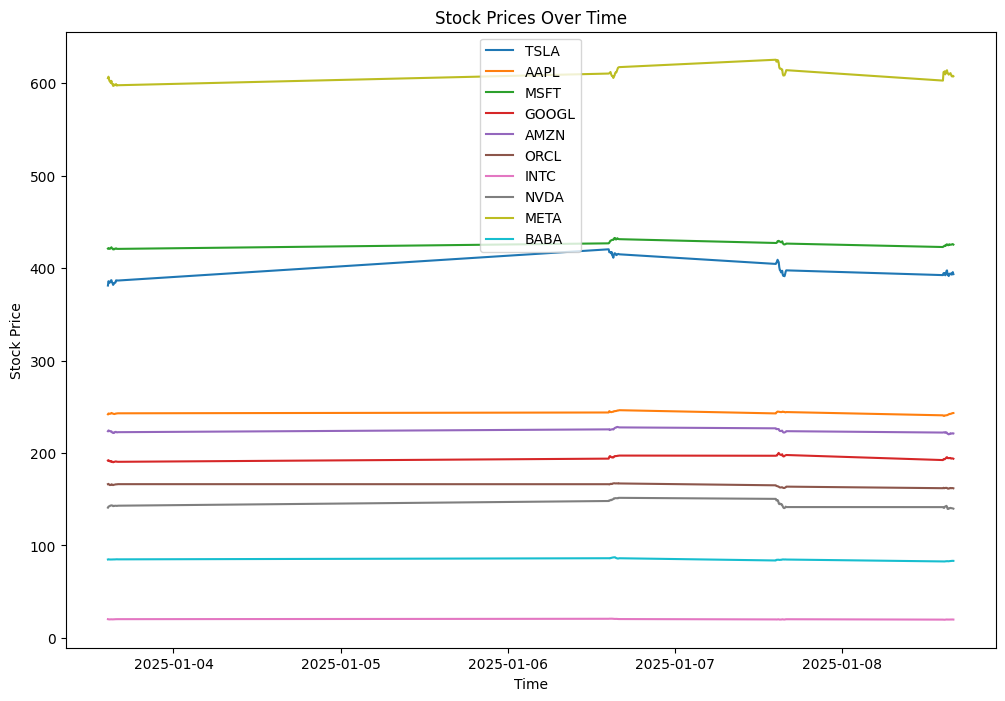

In [100]:
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()

In [101]:
#Using Tenserflow

In [102]:
#Using LSTM
def prepare_lstm_data(X, y, time_steps=1):
    X_lstm = []
    y_lstm = []
    for i in range(len(X) - time_steps):
        X_lstm.append(X[i:(i + time_steps)])
        y_lstm.append(y.iloc[i + time_steps])
    return np.array(X_lstm), np.array(y_lstm)

In [103]:
time_steps = 5  # You can adjust this
X_lstm, y_lstm = prepare_lstm_data(X_train, y_train, time_steps)
X_lstm_test, y_lstm_test = prepare_lstm_data(X_test, y_test, time_steps)

In [104]:
lstm_model = Sequential([
    Input(shape=(time_steps, X.shape[1])),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [105]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [106]:
history_lstm = lstm_model.fit(X_lstm, y_lstm, validation_split=0.2, epochs=20, batch_size=32)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.5175 - loss: 0.6922 - val_accuracy: 0.5462 - val_loss: 0.6925
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5333 - loss: 0.6916 - val_accuracy: 0.5630 - val_loss: 0.6905
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5446 - loss: 0.6888 - val_accuracy: 0.5630 - val_loss: 0.6895
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5380 - loss: 0.6896 - val_accuracy: 0.5630 - val_loss: 0.6899
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5346 - loss: 0.6905 - val_accuracy: 0.5630 - val_loss: 0.6898
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5472 - loss: 0.6892 - val_accuracy: 0.5630 - val_loss: 0.6896
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5477 - loss: 0.6892 - val_accuracy: 0.5630 - val_loss: 0.6896
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5495 - loss: 0.6857 - val_accuracy: 0.5630 -

In [107]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_lstm_test, y_lstm_test)
print(f"LSTM Model Loss: {lstm_loss:.4f}")
print(f"LSTM Model Accuracy: {lstm_accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4469 - loss: 0.7211
LSTM Model Loss: 0.7209
LSTM Model Accuracy: 0.4552


In [108]:
predictions_lstm = (lstm_model.predict(X_lstm_test) > 0.5).astype(int).flatten()

accuracy_lstm = accuracy_score(y_lstm_test, predictions_lstm)
f1_lstm = f1_score(y_lstm_test, predictions_lstm)
precision_lstm = precision_score(y_lstm_test, predictions_lstm)
recall_lstm = recall_score(y_lstm_test, predictions_lstm)

print(f"LSTM Model Accuracy: {accuracy_lstm:.2f}")
print(f"LSTM F1 Score: {f1_lstm:.2f}")
print(f"LSTM Precision: {precision_lstm:.2f}")
print(f"LSTM Recall: {recall_lstm:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step
LSTM Model Accuracy: 0.46
LSTM F1 Score: 0.60
LSTM Precision: 0.47
LSTM Recall: 0.83


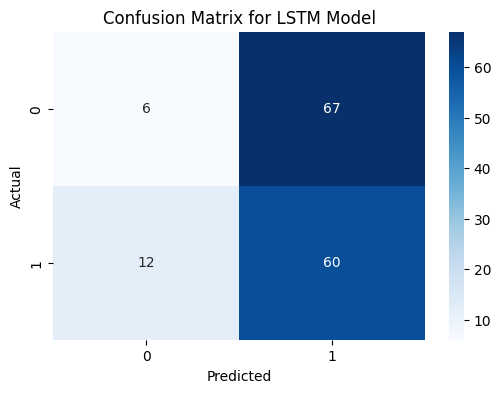

In [109]:
conf_matrix_lstm = confusion_matrix(y_lstm_test, predictions_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LSTM Model')
plt.show()

In [110]:
def predict_trends_lstm(data, model, time_steps):
    tomorrow_predictions_lstm = {}
    for ticker in tickers:
        stock_data = data[ticker].tail(time_steps)
        if len(stock_data) >= time_steps:
            X_future = stock_data[['Return', 'SMA_5', 'SMA_20', 'RSI']].tail(time_steps).values
            X_future = X_future.reshape((1, time_steps, X_future.shape[1]))
            prediction = model.predict(X_future)
            tomorrow_predictions_lstm[ticker] = "Up" if prediction > 0.5 else "Down"
        else:
            tomorrow_predictions_lstm[ticker] = "No Data"
    return tomorrow_predictions_lstm

In [111]:
trending_stocks_lstm = predict_trends_lstm(all_data, lstm_model, time_steps)
print("LSTM Predicted Trending Stocks for Tomorrow:")
print(trending_stocks_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
LSTM Predicted Trending Stocks for Tomorrow:
{'TSLA': 'Down', 'AAPL': 'Down', 'MSFT': 'Down', 'GOOGL': 'Down', 'AMZN': 'Down', 'ORCL': 'Down', 'INTC': 'Up', 'NVDA': 'Down', 'META': 'Down', 'BABA': 'Down'}


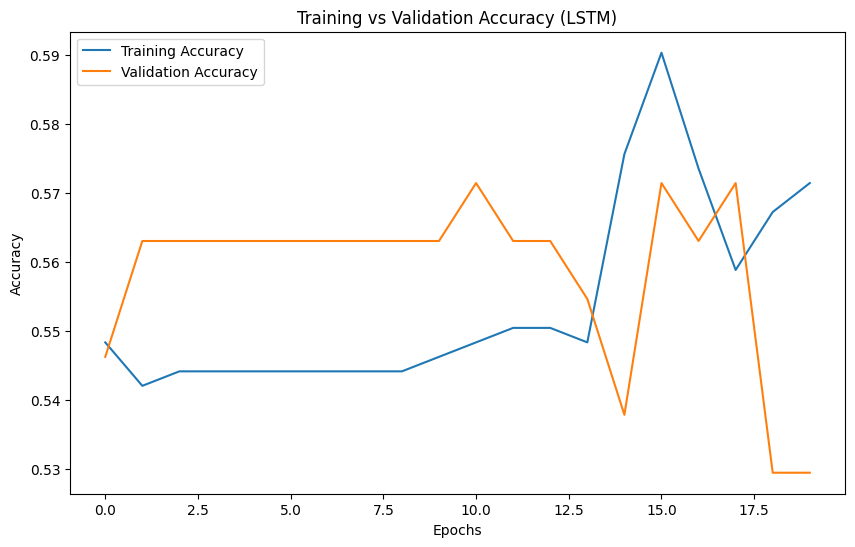

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (LSTM)')
plt.legend()
plt.show()

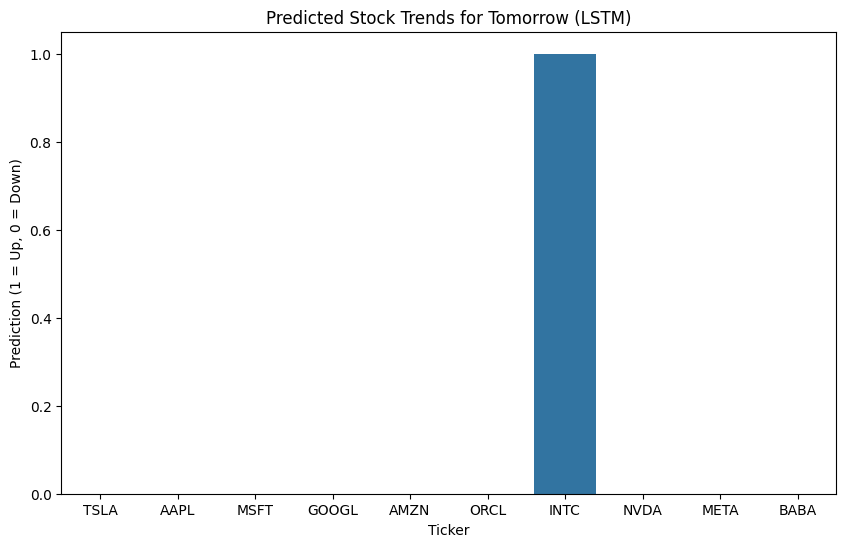

In [113]:
plt.figure(figsize=(10, 6))
trending_df_lstm = pd.DataFrame(list(trending_stocks_lstm.items()), columns=['Ticker', 'Prediction'])
trending_df_lstm['Prediction'] = trending_df_lstm['Prediction'].map({'Up': 1, 'Down': 0})
sns.barplot(x='Ticker', y='Prediction', data=trending_df_lstm.dropna())
plt.ylabel('Prediction (1 = Up, 0 = Down)')
plt.title('Predicted Stock Trends for Tomorrow (LSTM)')
plt.show()

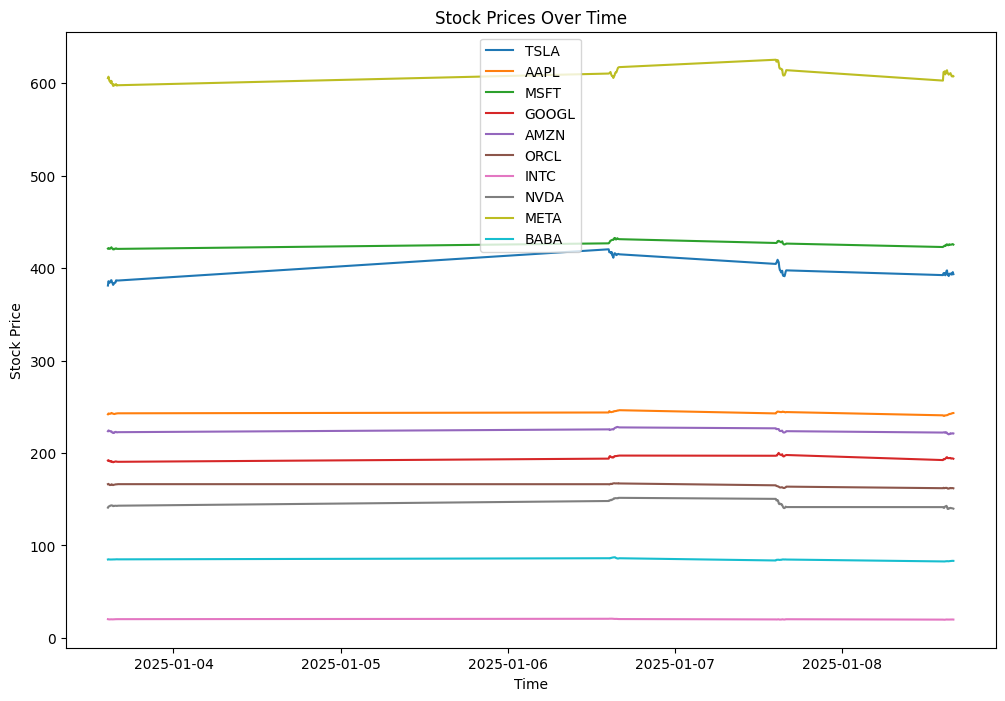

In [114]:
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()

In [115]:
#Dense Neural Network
dnn_model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define the input shape using Input layer
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # For binary classification
])
dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [116]:
loss, accuracy = dnn_model.evaluate(X_test, y_test)
print(f"Dense Neural Network Model Accuracy: {accuracy:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4634 - loss: 0.7080 
Dense Neural Network Model Accuracy: 0.48


In [117]:
history_dnn = dnn_model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32)
print(history_dnn.history.keys())

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5046 - loss: 0.7001 - val_accuracy: 0.5583 - val_loss: 0.6865
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4833 - loss: 0.7080 - val_accuracy: 0.5583 - val_loss: 0.6847
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5360 - loss: 0.6884 - val_accuracy: 0.5583 - val_loss: 0.6828
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5577 - loss: 0.6840 - val_accuracy: 0.5583 - val_loss: 0.6806
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5376 - loss: 0.6892 - val_accuracy: 0.5500 - val_loss: 0.6793
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5302 - loss: 0.6878 - val_accuracy: 0.5417 - val_loss: 0.6800
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5492 - loss: 0.6886 - val_accuracy: 0.5417 - val_loss: 0.6796
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5772 - loss: 0.6847 - val_accuracy: 0.5250 - v

In [118]:
predictions_dnn = (dnn_model.predict(X_test) > 0.5).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


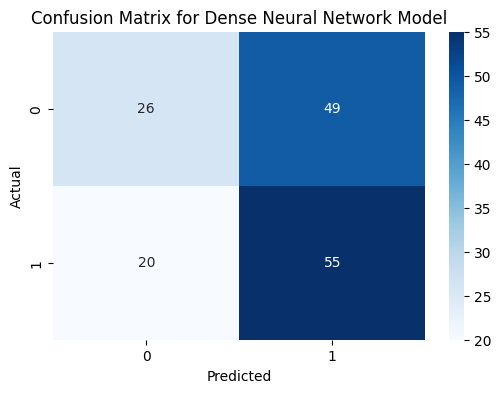

In [119]:
conf_matrix_dnn = confusion_matrix(y_test, predictions_dnn)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_dnn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Dense Neural Network Model')
plt.show()

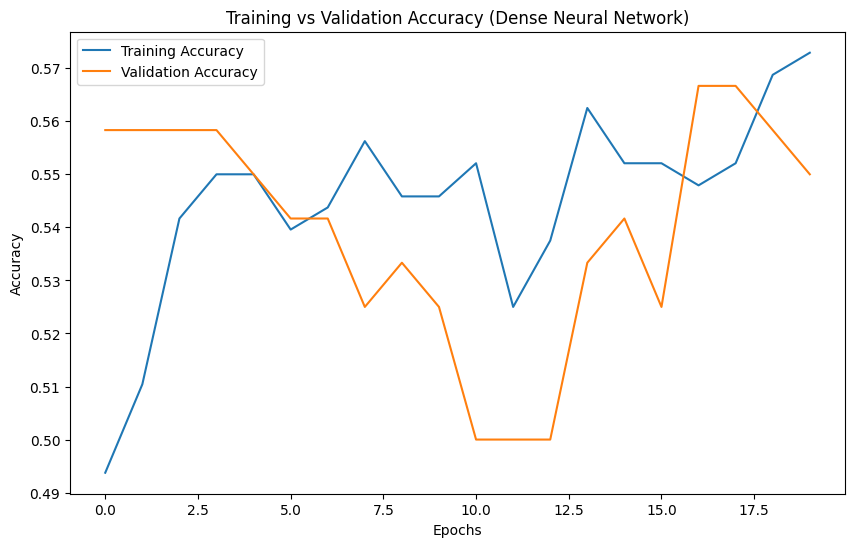

In [120]:
plt.figure(figsize=(10, 6))
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Dense Neural Network)')
plt.legend()
plt.show()

In [121]:
def predict_trending_stocks_dnn(data, model, scaler):
    tomorrow_predictions = {}
    for ticker in tickers:
        stock_data = data[ticker]
        X_future = stock_data[['Return', 'SMA_5', 'SMA_20', 'RSI']].dropna().tail(1)
        if not X_future.empty:
            X_future = scaler.transform(X_future)
            prediction = (model.predict(X_future) > 0.5).astype(int)[0][0]
            tomorrow_predictions[ticker] = "Up" if prediction == 1 else "Down"
        else:
            tomorrow_predictions[ticker] = "No Data"
    return tomorrow_predictions

In [122]:
trending_stocks_dnn = predict_trending_stocks_dnn(all_data, dnn_model, scaler)
print("Trending Stocks for Tomorrow (Dense Neural Network):")
print(trending_stocks_dnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Trending Stocks for Tomorrow (Dense Neural Network):
{'TSLA': 'Up', 'AAPL': 'Up', 'MSFT': 'Down', 'GOOGL': 'Down', 'AMZN': 'Down', 'ORCL': 'Down', 'INTC': 'Down', 'NVDA': 'Up', 'META': 'Up', 'BABA': 'Up'}


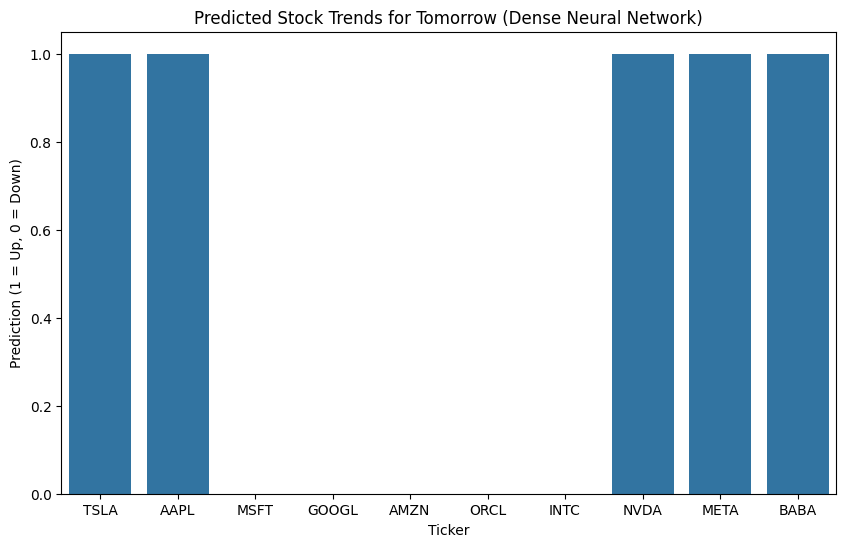

In [123]:
plt.figure(figsize=(10, 6))
trending_df_dnn = pd.DataFrame(list(trending_stocks_dnn.items()), columns=['Ticker', 'Prediction'])
trending_df_dnn['Prediction'] = trending_df_dnn['Prediction'].map({'Up': 1, 'Down': 0})
sns.barplot(x='Ticker', y='Prediction', data=trending_df_dnn.dropna())
plt.ylabel('Prediction (1 = Up, 0 = Down)')
plt.title('Predicted Stock Trends for Tomorrow (Dense Neural Network)')
plt.show()

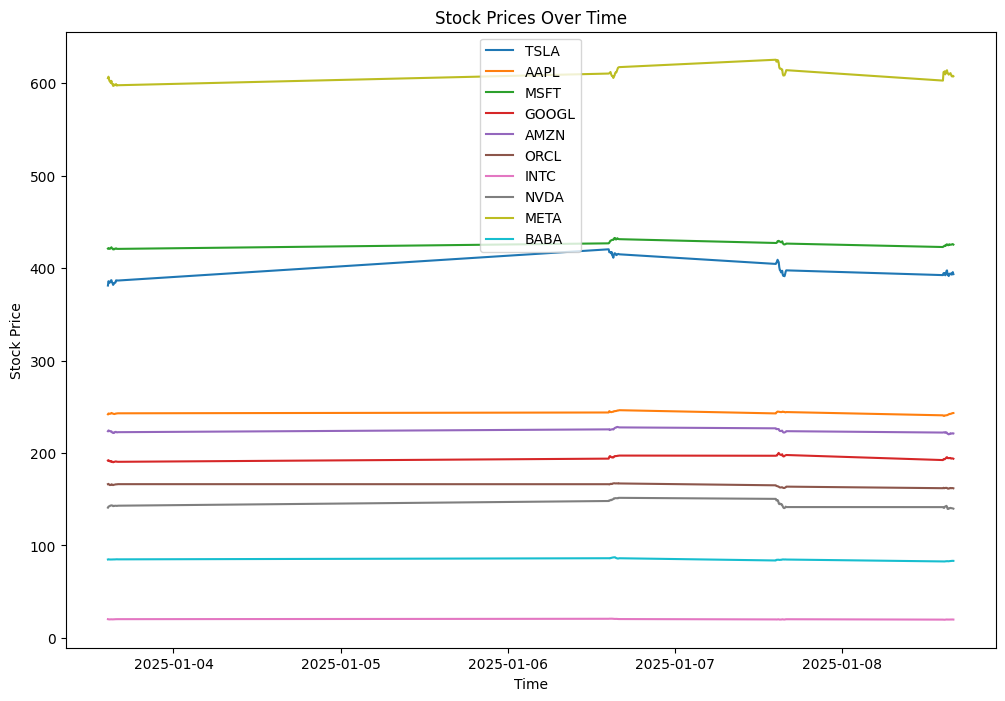

In [124]:

plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()


In [125]:
# Save the trained model to the specified path
dnn_model.save('C:\\Stock_pred\\saved_model\\dnn_model.keras')

In [126]:
lstm_model.save('C:\\Stock_pred\\saved_model\\lstm_model.keras')

In [127]:
# Export the trained model to the specified path
dnn_model.export('C:\\Stock_pred\\saved_model\\my_model_dir')

INFO:tensorflow:Assets written to: C:\Stock_pred\saved_model\my_model_dir\assets


INFO:tensorflow:Assets written to: C:\Stock_pred\saved_model\my_model_dir\assets


Saved artifact at 'C:\Stock_pred\saved_model\my_model_dir'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='keras_tensor_18')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2377680606352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377680612880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377680606544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377680609808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377680606736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377680610576: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [128]:
lstm_model.export('C:\\Stock_pred\\saved_model\\my_model_dir')

INFO:tensorflow:Assets written to: C:\Stock_pred\saved_model\my_model_dir\assets


INFO:tensorflow:Assets written to: C:\Stock_pred\saved_model\my_model_dir\assets


Saved artifact at 'C:\Stock_pred\saved_model\my_model_dir'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5, 4), dtype=tf.float32, name='keras_tensor_12')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2377588568144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377588568336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377588568912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377588571600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377588571792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377588569296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377588567760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2377588565840: TensorSpec(shape=(), dtype=tf.resource, name=None)
